In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<b>Idea: Member based community detection for T2</b>  
1. vendor wallets filtered nur upper limit  
2. review matching t2  
3. 2 dimensional plotting von allen transactions, die an vendor zahlen mit farbe = known t2  
	-> clustering / member based community detection

T2 Clustering - Properties:  
Direct Transaction properties:  
- indegree  
- outdegree  
- indegree:outdegree  
Indirect transaction properties:  
- in-&outdegree of sends addresses  
- in-&outdegree of receives addresses: known vendor addresses/all/mean of all  
- script type of sends addresses  
- maxdate - mindate of sends addresses  

Hypothesis: All addresses of the market use the same script type  

Further property ideas:  
- amount in euro / is amount in euro glatt = nice amount e.g. 1000  
( - "sends address" sends to speculated T2 transaction)  

1. get dataframe in python: all transactions sending to known vendor addresses  
2. including all properties  
3. transform to a 2 dimensional space & plot (PCA, t-sne, or similar)  
4. apply clustering technique  

build so it can be redone once we have more T2 addresses!  
-> T2 transaction set + vendor wallets as input  

# 0. Load Connections, Data & Helper Functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interpn

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE as TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [4]:
#import mariadb
import tqdm
import pickle
import pandas as pd
import mysql.connector
from decimal import Decimal
from neo4j import GraphDatabase
from datetime import timedelta

In [5]:
df_pw = pd.read_csv("pw.csv", delimiter=",")

In [6]:
berlusconi_reviews  = pd.read_csv('reviews_price_btc.csv')

In [7]:
vendor_wal_filtered=pd.read_csv('vendor_wallets_filtered.csv')

In [8]:
#!/usr/bin/env python
# coding: utf-8

# # Function to start neo4j session

from neo4j import GraphDatabase
import pandas as pd
import os


def startNeo4jSession(credentials  = 'pw.csv',
                      port = 7687):

    try:
        credentials = pd.read_csv(credentials)
    except:
        raise Exception('credentials could not be found')

    uri = "neo4j://localhost:" + str(port)


    username = credentials['name'][0]
    password = credentials['password'][0]
    
    driver = GraphDatabase.driver(uri, auth=(username, password))
    session = driver.session()
    return driver, session

In [9]:
driver, session = startNeo4jSession()

In [11]:
# plot with density
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

# Community Detection

## 1. Load identified vendor addresses

In [12]:
df_vendoraddresses = pd.read_csv("final_results.csv")
len(df_vendoraddresses)

38

## 2. Load transactions sending to vendor addresses with properties

In [13]:
# load transactions matching our pattern
df_pattern = pd.DataFrame()

# include loop through all identified t2s
for row in df_vendoraddresses.itertuples():
#     print("Start for: ", row.Address)
    candidate = row.CandidateAddress
    observedChange = str(0.01 * 100000000)
    
    neo_results = []

    # initial query retrieving all input addresses
    neo_query = session.run("""
    WITH 
    '""" + candidate + """' as vendorCandidate,
    """ + observedChange + """ as usualChange
    MATCH (payout:Transaction)-[RECEIVES]->(vendor:Address)
    WHERE vendor.address = vendorCandidate and payout.outDegree = 2 and vendor.totalMoneyReceived < 6000000000
    WITH payout, usualChange, vendor
    MATCH (in:Address)-[SENDS]->(payout)-[r1:RECEIVES]->(change1:Address)
    WHERE 0.85 * usualChange <= r1.value <= 1.15 * usualChange 
    AND change1 <> vendor
    AND (change1.address STARTS WITH "3" OR change1.address STARTS WITH "bc1")
    AND (in.address STARTS WITH "3" OR in.address STARTS WITH "bc1")
    WITH payout, vendor
    MATCH (payout)-[r:RECEIVES]->(vendor)
    RETURN DISTINCT payout.txid
    """)
    for r in neo_query:
        neo_results.append(r[0])

    # all transactions spending to vendor wallet addresses
    df_pattern = pd.concat([df_pattern,pd.DataFrame(data=neo_results,columns=["pattern_txid"])], ignore_index = True)

len(df_pattern)

185

In [14]:
# load all transactions
df_results = pd.DataFrame()

# loop through all addresses
for row in df_vendoraddresses.itertuples():
#     print("Start for: ", row.Address)

    # initial query retrieving all input addresses
    query = f"""MATCH (input:Address)-[:SENDS]->(t2:Transaction)-[:RECEIVES]->(output:Address {{address: \'{row.CandidateAddress}\'}}) 
                WHERE input.address <> 'unknown'
                RETURN t2.txid, t2.inDegree, t2.outDegree,  t2.inDegree / t2.outDegree as degreeRatio,
                min(input.inDegree) as minInInDegree, max(input.inDegree) as maxInInDegree, avg(input.inDegree) as avgInInDegree,
                min(input.outDegree) as minInOutDegree, max(input.outDegree) as maxInOutDegree, avg(input.outDegree) as avgInOutDegree,
                min(output.inDegree) as minOutInDegree, max(output.inDegree) as maxOutInDegree, avg(output.inDegree) as avgOutInDegree,
                min(output.outDegree) as minOutOutDegree, max(output.outDegree) as maxOutOutDegree, avg(output.outDegree) as avgOutOutDegree,
                collect(input.address), collect(output.address)"""

    # all transactions spending to vendor wallet addresses
    df_results = pd.concat([df_results,pd.DataFrame(session.run(query).values(), 
                                                   columns=['txid','T2InDegree','T2OutDegree', "degreeRatio",
                                                            'minInInDegree','maxInInDegree','avgInInDegree',
                                                            'minInOutDegree','maxInOutDegree','avgInOutDegree',
                                                            'minOutInDegree','maxOutInDegree','avgOutInDegree',
                                                            'minOutOutDegree','maxOutOutDegree','avgOutOutDegree',
                                                            'inputAddresses','outputAddresses'
                                                           ])], ignore_index = True)


len(df_results)

2482

In [15]:
# check script types of collected input addresses
df_results['inputScriptP2PKH'] = df_results["inputAddresses"].apply(lambda x_list: 1 if any(x.startswith('1') for x in x_list) else 0)
df_results['inputScriptP2SH'] = df_results["inputAddresses"].apply(lambda x_list: 1 if any(x.startswith('3') for x in x_list) else 0)
df_results['outputScriptP2PKH'] = df_results["outputAddresses"].apply(lambda x_list: 1 if any(x.startswith('1') for x in x_list) else 0)
df_results['outputScriptP2SH'] = df_results["outputAddresses"].apply(lambda x_list: 1 if any(x.startswith('3') for x in x_list) else 0)

In [16]:
# add column whether it matches the pattern
df_results["isT2"] = df_results["txid"].isin(df_pattern["pattern_txid"].unique())

In [17]:
df_results.groupby("isT2").count()[["txid"]]

,txid
isT2,
False,2297
True,185


## 3. Get 1000 random transactions

In [18]:
df_random = pd.DataFrame()

query = f"""MATCH (output:Address)
                WITH output  limit 2000
                MATCH (input:Address)-[:SENDS]->(t2:Transaction)-[:RECEIVES]->(output) 
                WHERE input.address <> 'unknown'
                AND t2.inDegree <> 1
                RETURN t2.txid, t2.inDegree, t2.outDegree,  t2.inDegree / t2.outDegree as degreeRatio,
                min(input.inDegree) as minInInDegree, max(input.inDegree) as maxInInDegree, avg(input.inDegree) as avgInInDegree,
                min(input.outDegree) as minInOutDegree, max(input.outDegree) as maxInOutDegree, avg(input.outDegree) as avgInOutDegree,
                min(output.inDegree) as minOutInDegree, max(output.inDegree) as maxOutInDegree, avg(output.inDegree) as avgOutInDegree,
                min(output.outDegree) as minOutOutDegree, max(output.outDegree) as maxOutOutDegree, avg(output.outDegree) as avgOutOutDegree,
                collect(input.address), collect(output.address)
                limit 1000"""

df_random = pd.DataFrame(session.run(query).values(), columns=['txid','T2InDegree','T2OutDegree', "degreeRatio",
                                                            'minInInDegree','maxInInDegree','avgInInDegree',
                                                            'minInOutDegree','maxInOutDegree','avgInOutDegree',
                                                            'minOutInDegree','maxOutInDegree','avgOutInDegree',
                                                            'minOutOutDegree','maxOutOutDegree','avgOutOutDegree',
                                                            'inputAddresses','outputAddresses'])

len(df_random)

1000

In [19]:
# check script types of collected input addresses
df_random['inputScriptP2PKH'] = df_random["inputAddresses"].apply(lambda x_list: 1 if any(x.startswith('1') for x in x_list) else 0)
df_random['inputScriptP2SH'] = df_random["inputAddresses"].apply(lambda x_list: 1 if any(x.startswith('3') for x in x_list) else 0)
df_random['outputScriptP2PKH'] = df_random["outputAddresses"].apply(lambda x_list: 1 if any(x.startswith('1') for x in x_list) else 0)
df_random['outputScriptP2SH'] = df_random["outputAddresses"].apply(lambda x_list: 1 if any(x.startswith('3') for x in x_list) else 0)

In [20]:
# set isT2 to no
df_random = df_random[~df_random["txid"].isin(df_results["txid"])]
df_random["isT2"] = False
len(df_random)

1000

In [21]:
# combine all data into one dataframe
df_transactions = pd.concat([df_results,df_random],ignore_index=True)
len(df_transactions)

3482

In [22]:
# scale all features
df_scaled  = df_transactions.drop(columns=['txid', 'inputAddresses','outputAddresses','isT2'])
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_scaled), columns = df_scaled.columns)
df_transactions = df_scaled.join(df_transactions[['txid', 'inputAddresses','outputAddresses','isT2']])
print(len(df_transactions))
df_transactions.head()

3482


,T2InDegree,T2OutDegree,degreeRatio,minInInDegree,maxInInDegree,avgInInDegree,minInOutDegree,maxInOutDegree,avgInOutDegree,minOutInDegree,...,maxOutOutDegree,avgOutOutDegree,inputScriptP2PKH,inputScriptP2SH,outputScriptP2PKH,outputScriptP2SH,txid,inputAddresses,outputAddresses,isT2
0,0.143186,-0.148049,0.319417,-0.146012,-0.162913,-0.153002,-0.148239,-0.166290,-0.155778,-0.596154,...,-0.927825,-0.927817,-0.892579,0.870968,0.360767,-0.360767,fd91524c1107e031b0a7cc1a0904518fea6720df4e9ff0...,"[33LQ1Ec3Te4iMgerji6YmSMHZ39HtStbJa, 34rQkGaSc...","[1My4BZTaHX2k8sSpAec6p3qoGikgGhYcDJ, 1My4BZTaH...",True
1,1.999651,-0.134457,1.299510,-0.146012,-0.136959,-0.152182,-0.148239,-0.142180,-0.155015,-0.596154,...,-0.927825,-0.927817,-0.892579,0.870968,0.360767,-0.360767,d877cc21faee2ce511a8de4becbf5a9d79d5f25ffb2a2d...,"[3LDcYe43Jb8YwKLoqsxJ6Mqkkfgkv9Y9mF, 3HjMQzhik...","[1My4BZTaHX2k8sSpAec6p3qoGikgGhYcDJ, 1My4BZTaH...",False
2,-0.079590,-0.141253,-0.072620,-0.145774,-0.159346,-0.149384,-0.147979,-0.162415,-0.151827,-0.596154,...,-0.927825,-0.927817,-0.892579,0.870968,0.360767,-0.360767,b9beaf0982fbac9c30173ba427811c765307a22c959373...,"[3AoWB5SYuX813W1oLxxhYFKxu67JfwwFay, 3JbMAKR3q...","[1My4BZTaHX2k8sSpAec6p3qoGikgGhYcDJ, 1My4BZTaH...",False
3,-0.079590,-0.148049,0.123398,-0.146012,-0.167636,-0.153627,-0.148239,-0.171440,-0.156463,-0.596681,...,-0.956075,-0.956068,-0.892579,0.870968,-2.771875,2.771875,d8917e0d45dcc8e4779588dd6113e846b7ef161303ef1a...,"[3FkUD3jSZgX21DVFqZTgaoKnYVBPxwE48L, 3AmHLXYuH...","[3FW2rWrRQhfCM1ptFen96644rjESgT1pxk, 3FW2rWrRQ...",True
4,-0.079590,-0.148049,0.123398,-0.146012,-0.167827,-0.153713,-0.148239,-0.171647,-0.156556,-0.596681,...,-0.956075,-0.956068,-0.892579,0.870968,-2.771875,2.771875,0b2fb0fb7e1f9e918274036903e1aaf3f1f5b02f4831b2...,"[3GjpvVBQcNEF5nyauUGU4AKCJg86T1hm9X, 3FDNSBS77...","[3LSG4dW8xhvXMrxa7LJUN28vAyGkSwC4KX, 3LSG4dW8x...",True


## 4. Transform & Plot Transactions
## 4.1 Only transactions to known vendor addresses

In [23]:
df_plotk = df_transactions[df_transactions["txid"].isin(df_results["txid"])].drop(columns=['txid', 'inputAddresses','outputAddresses','isT2'])

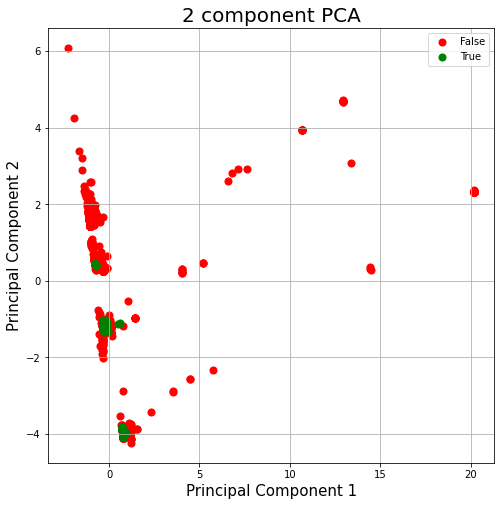

In [24]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_plotk)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2']).reset_index(drop=True)
df_pca = pd.concat([principalDf, df_transactions[['isT2']].reset_index(drop=True)], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [False,True]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['isT2'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'principal component 1']
               , df_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

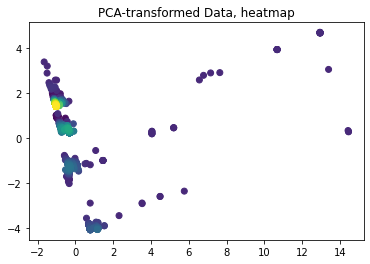

In [25]:
plot1 = density_scatter( principalDf["principal component 1"], principalDf["principal component 2"], bins = [30,30])
plot1.set(title="PCA-transformed Data, heatmap")
plt.show()

## 4.2 All transactions

In [26]:
df_plot = df_transactions.drop(columns=['txid', 'inputAddresses','outputAddresses','isT2'])

In [27]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_plot)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2']).reset_index(drop=True)

In [28]:
df_pca = pd.concat([principalDf, df_transactions[['isT2']].reset_index(drop=True)], axis = 1)

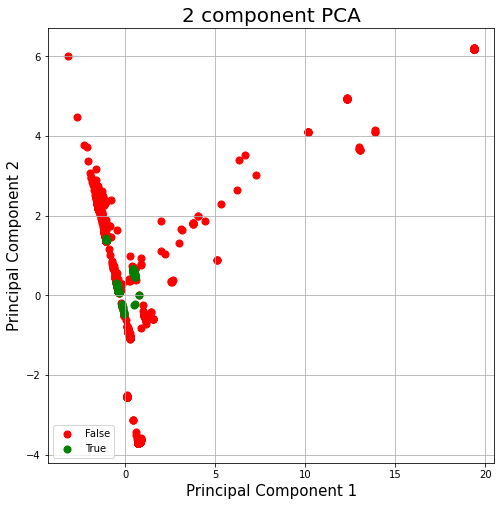

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [False,True]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['isT2'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'principal component 1']
               , df_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

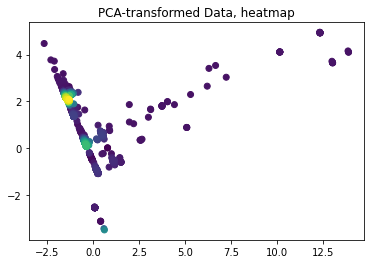

In [30]:
plot1 = density_scatter( principalDf["principal component 1"], principalDf["principal component 2"], bins = [30,30])
plot1.set(title="PCA-transformed Data, heatmap")
plt.show()

In [31]:
# additionally apply different transformer: e.g. t-sne!
# tsne: t-distributed stochastic neighbor embedding
# NOTE: THIS TAKES A FEW MINUTES
a_tsne = TSNE(n_components=2).fit_transform(df_plot)

In [32]:
df_tsne = pd.concat([pd.DataFrame(data=a_tsne, columns= ["Component 1", "Component 2"]), df_transactions[['isT2']].reset_index(drop=True)], axis = 1)

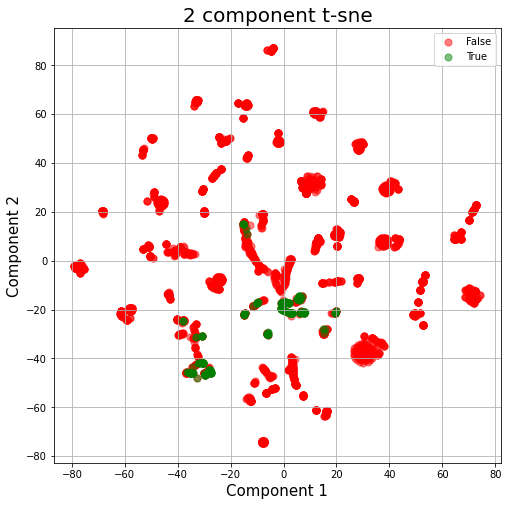

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2 component t-sne', fontsize = 20)
targets = [False,True]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_tsne['isT2'] == target
    ax.scatter(df_tsne.loc[indicesToKeep, 'Component 1']
               , df_tsne.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 50,
              alpha = 0.5)
ax.legend(targets)
ax.grid()

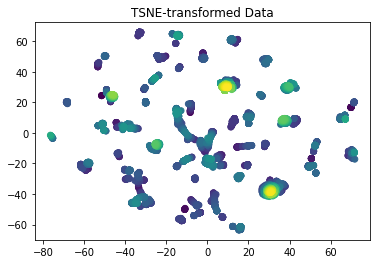

In [34]:
plot1 = density_scatter( df_tsne[(~df_tsne["Component 1"].isna() & ~df_tsne["Component 2"].isna())]["Component 1"], 
                        df_tsne[(~df_tsne["Component 1"].isna() & ~df_tsne["Component 2"].isna())]["Component 2"], bins = [30,30])
plot1.set(title="TSNE-transformed Data")
plt.show()

### 4.3 Manually selected features

In [35]:
df_plot.columns

Index(['T2InDegree', 'T2OutDegree', 'degreeRatio', 'minInInDegree',
       'maxInInDegree', 'avgInInDegree', 'minInOutDegree', 'maxInOutDegree',
       'avgInOutDegree', 'minOutInDegree', 'maxOutInDegree', 'avgOutInDegree',
       'minOutOutDegree', 'maxOutOutDegree', 'avgOutOutDegree',
       'inputScriptP2PKH', 'inputScriptP2SH', 'outputScriptP2PKH',
       'outputScriptP2SH'],
      dtype='object')

In [36]:
manual_cols = ['T2InDegree', 'T2OutDegree', 'degreeRatio',
               'inputScriptP2PKH', 'inputScriptP2SH'#, 'outputScriptP2PKH', 'outputScriptP2SH'
              ]

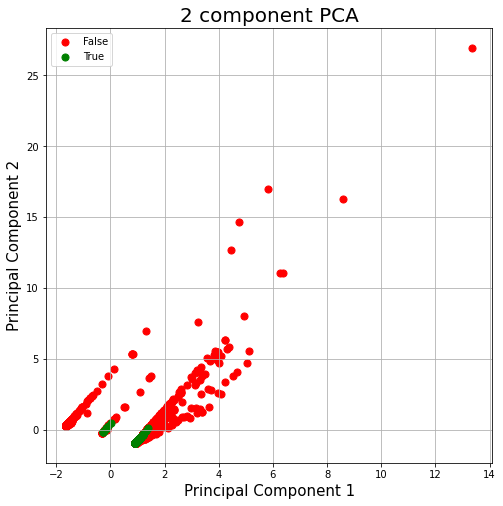

In [37]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_plot[manual_cols])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2']).reset_index(drop=True)
df_pca = pd.concat([principalDf, df_transactions[['isT2']].reset_index(drop=True)], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [False,True]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['isT2'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'principal component 1']
               , df_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [38]:
# additionally apply different transformer: e.g. t-sne!
# tsne: t-distributed stochastic neighbor embedding
# NOTE: THIS TAKES A FEW MINUTES
a_tsne = TSNE(n_components=2).fit_transform(df_plot[manual_cols])

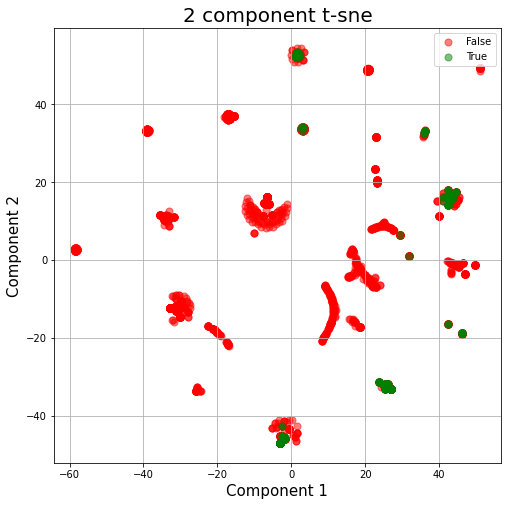

In [39]:
df_tsne = pd.concat([pd.DataFrame(data=a_tsne, columns= ["Component 1", "Component 2"]), df_transactions[['isT2']].reset_index(drop=True)], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2 component t-sne', fontsize = 20)
targets = [False,True]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_tsne['isT2'] == target
    ax.scatter(df_tsne.loc[indicesToKeep, 'Component 1']
               , df_tsne.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 50,
              alpha = 0.5)
ax.legend(targets)
ax.grid()

## 5. Cluster Transactions 
Based on normal dimensions, scaled data, manual feature selection.  
Algorithms/Models: https://scikit-learn.org/stable/modules/clustering.html  
Noise = cluster number -1

### DBScan

In [40]:
def applyDBScan(columns,eps,min_samples):
    estimator = DBSCAN(eps=eps, min_samples=min_samples)
    estimator.fit(df_transactions[columns].fillna(0))                   
    new_df = df_transactions.join(pd.Series(estimator.labels_, name="clusters"))
    
    dbscan_results = pd.DataFrame(columns=['cluster_id', 'isT2', 'cluster_size'])
    for cluster_id in new_df["clusters"].unique(): 
        c = new_df.groupby(['clusters']).get_group(cluster_id)[['txid', 'isT2']]
        isT2 = c['isT2'] == True
        numberT2Tx = c[isT2]['isT2'].count()
        df2 = pd.DataFrame([[cluster_id, numberT2Tx, len(new_df.groupby(['clusters']).get_group(cluster_id)['txid'].values)]],
                       columns=['cluster_id', 'isT2', 'cluster_size'])
        dbscan_results = pd.concat([dbscan_results, df2], ignore_index = True)

    return dbscan_results

#### 4.1.1 All features

In [41]:
applyDBScan(df_plot.columns,0.25,10)

,cluster_id,isT2,cluster_size
0,0,101,272
1,-1,10,393
2,1,65,259
3,2,0,76
4,3,0,38
5,4,0,129
6,5,0,354
7,6,6,125
8,7,3,12
9,8,0,961


#### 4.1.2 Manual Columns

In [42]:
applyDBScan(manual_cols,0.25,10)

,cluster_id,isT2,cluster_size
0,0,175,1730
1,-1,1,256
2,1,0,1469
3,2,9,27
